# NMR Inversion Recovery Analysis in Python

* **Author:** Seth Veenbaas
* **Last Updated:** 8/30/24

## Objective
In this notebook, we will learn the basics of working with scientific data in Python, focusing on an NMR inversion recovery experiment. We will import experimental data into a Pandas DataFrame, calculate the T<sub>1</sub> relaxation times and ideal an ideal d<sub>1</sub> delay time, and visualize the fitted data.

## Inversion recovery experiment
The inversion-recovery experiment measures T1 relaxation times of any nucleus. If the net magnetization is placed along the -z axis, it will gradually return to its equilibrium position along the +z axis at a rate governed by T1. The equation governing this behavior as a function of the time t after its displacement is: 

M<sub>z</sub>(t) = M<sub>z, eq</sub> * (1 - 2 e<sup>-t/T<sub>1</sub></sup>)

The basic pulse sequence consists of an 180<sup>°</sup> pulse that inverts the magnetization to the -z axis. During the following delay, relaxation along the longitudinal plane takes place. Magnetization comes back to the original equilibrium z-magnetization. A 90<sup>°</sup> pulse creates transverse magnetization. The experiment is repeated for a series of delay values taken from a variable delay list. A 1D spectrum is obtained for each value of vd and stored in a pseudo 2D dataset. The longer the relaxation delay (d<sub>1</sub>) is, the more precise the T<sub>1</sub> measurement is. An ideal relaxation time (d<sub>1</sub>) can be calculated (aq = acquisition time):

 d<sub>1</sub> + aq = 5 * T<sub>1</sub>

![image.png](images/t1_relaxation_pulse_sequence.png)

More information:
https://imserc.northwestern.edu/downloads/nmr-t1.pdf

---

## 1. Importing Required Libraries

First, let's import the python libraries/packages we need to work with the data.


In [13]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import re
import os

# Enable inline plotting
%matplotlib inline

# Set DataFrame precision to 3 decimal places
pd.set_option("display.precision", 3)


---

## 2. Importing the Data

We will now import the NMR inversion recovery data from a CSV file to a Pandas Dataframe (the excel of Python).

The data file `Ibuprofen-C13-invrec-data.csv` contains columns:

|       Time       |                 Peak<#>                  |
| :--------------: | :--------------------------------------: |
| Time of scan (s) | Signal for each carbon peak in ibuprofen |

**Pro Tip:** In computer languages you always start counting at 0 so the first peak in our dataset is labeled `Peak0`.

In [4]:
# Load the data from the CSV file
df = pd.read_csv('data/Ibuprofen-C13-invrec-data-mnova.csv', header=1)

# Formats MNOVA csv input and renames columns to peak chemical shift (ppm)
def rename_columns(df : pd.DataFrame):
    # Rename first column to time
    df = df.dropna(axis=1)
    df = df.drop([col for col in df.columns if "'" in col], axis=1)
    df = df.drop([col for col in df.columns if "#" in col], axis=1)
    df = df.rename(columns={'X(I)': 'Time'})


    # Regular expression to match "Integral(float1, float2)"
    pattern = r'Integral\((\d+\.\d+),(\d+\.\d+)\)'

    # Iterate over each column
    for col in df.columns:
        first_row_value = str(df[col].iloc[0])
        
        # Use regex to find the two float numbers in the string
        match = re.match(pattern, first_row_value)
        if match:
            float1 = float(match.group(1))
            float2 = float(match.group(2))
            # Calculate the median of the two floats
            median_value = round((float1 + float2) / 2, 1)
            # Rename the column
            df = df.rename(columns={col: f'{median_value}_ppm'})
    if any(index == 0 for index in df.index):
        df = df.drop(index=0, axis=0)
    df = df.astype(float)
    if '79.3_ppm' in df.columns:
        df = df.drop('79.3_ppm', axis=1)
    
    return df
df = rename_columns(df)

# Display the dataframe to understand its structure
df


,Time,183.7_ppm,143.4_ppm,139.3_ppm,132.3_ppm,130.3_ppm,47.5_ppm,24.9_ppm
1,0.062,-4684.675,-5499.795,-5036.193,-6258.796,-5560.295,-1331.859,-2792.253
2,0.125,-3658.109,-6311.520,-5046.871,-5070.044,-5501.243,-2232.157,-718.401
3,0.250,-3931.386,-4594.111,-6585.526,-4965.123,-4204.978,-4227.647,-2714.234
4,0.500,-3852.770,-3103.076,-4563.785,-3098.568,-3719.214,-2123.349,-399.047
5,1.000,-4292.297,-3898.902,-6335.422,-3270.550,-2361.015,600.839,234.864
6,2.000,-6274.636,-458.690,-4315.249,267.014,1098.219,2348.319,2742.474
7,4.000,-3083.688,632.667,-3011.320,2682.380,1102.794,4361.105,1551.448
8,8.000,-1456.791,339.541,1444.355,4345.313,3865.516,3288.270,1518.069
9,16.000,-1819.283,791.616,1181.459,4085.027,5653.630,3659.424,1841.427


---

## 3. Visualizing the Data

Let's create a function using MatPlotLib to visualize the raw data for all peaks.

**Function :** a module of code that is not run until called by subsequent code.

1. Define a function:

        def <function_name>(arguments):
            <function_code>

2. Run a function:

        <function_name>(arguments)


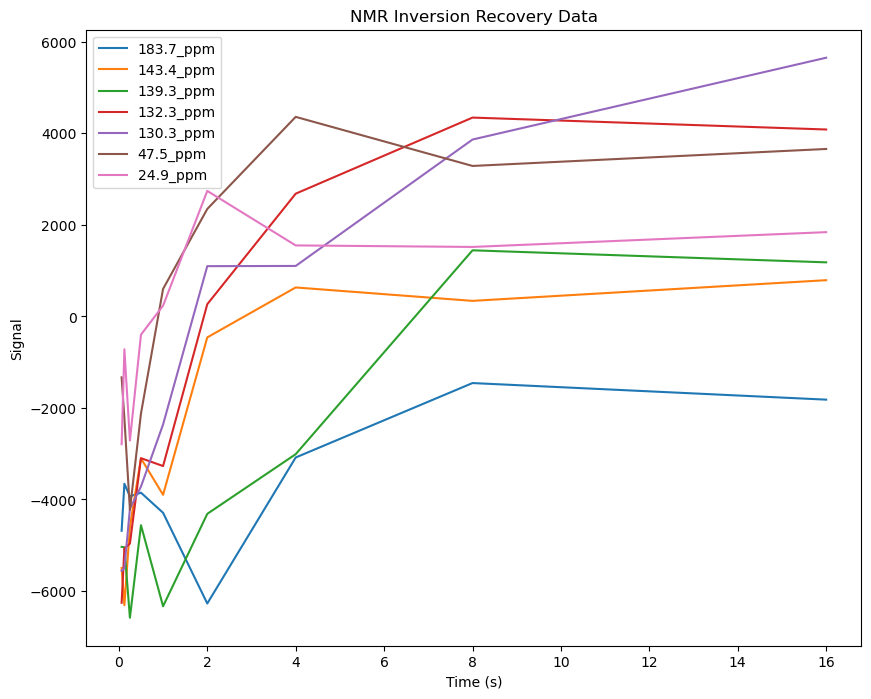

In [5]:
def plot_nmr_data(df : pd.DataFrame):
    plt.figure(figsize=(10, 8))
    
    for column in df.columns:
        if column != 'Time':
            plt.plot(df['Time'], df[column], label=column)
    
    plt.xlabel('Time (s)')
    plt.ylabel('Signal')
    plt.title('NMR Inversion Recovery Data')
    plt.legend()
    plt.show()

# Visualize the data
plot_nmr_data(df)


---

## 4. Calculating T1 Relaxation Time

To calculate the T1 relaxation time for each peak, we will fit the data to the inversion recovery model:

M<sub>z</sub>(t) = M<sub>z, eq</sub> * (1 - 2 e<sup>-t/T1</sup>) + C


In [6]:
# Function to model the inversion recovery curve
def inversion_recovery(t, M, T1, C):
    return M * (1 - 2 * np.exp(-t / T1)) + C

# Function to calculate T1 relaxation time for a given nucleus
def calculate_T1(df : pd.DataFrame, x_col : str, y_col : str):
    t = df[x_col].values
    y = df[y_col].values
    
    # Initial guess for A, T1, and C
    initial_guess = [max(y), 1, min(y)]
    
    # Fit the curve
    popt, _ = curve_fit(inversion_recovery, t, y, p0=initial_guess)
    
    # Return the fitted parameters and T1 value
    return popt, popt[1]


---

## 5. Visualizing the Fitted Data

Let's create a function to plot the data and the fitted curve.


In [7]:
def plot_fitted_data(df : pd.DataFrame, x_col : str, y_col : str, popt : numpy.ndarray):
    t = df[x_col].values
    y = df[y_col].values
    
    plt.figure(figsize=(8, 6))
    plt.scatter(t, y, label=f'{y_col} Data')
    plt.plot(t, inversion_recovery(t, *popt), label=f'Fit: T1 = {popt[1]:.3f} s', color='red')
    plt.xlabel('Time (s)')
    plt.ylabel('Signal')
    plt.title(f'Inversion Recovery Fit for {y_col}')
    plt.legend()
    plt.show()


---

## 6. Analyzing and Summarizing T1 Times for All Nuclei

Now, let's use the functions we created to calculate the T1 relaxation time for each nucleus and visualize the fits.


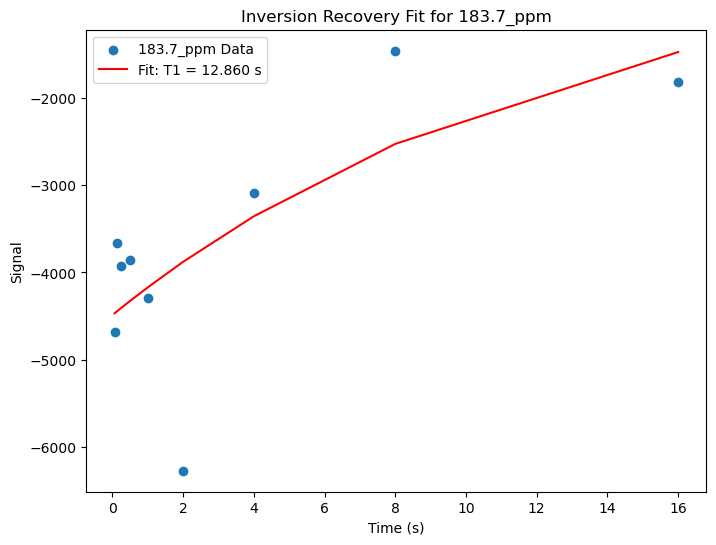

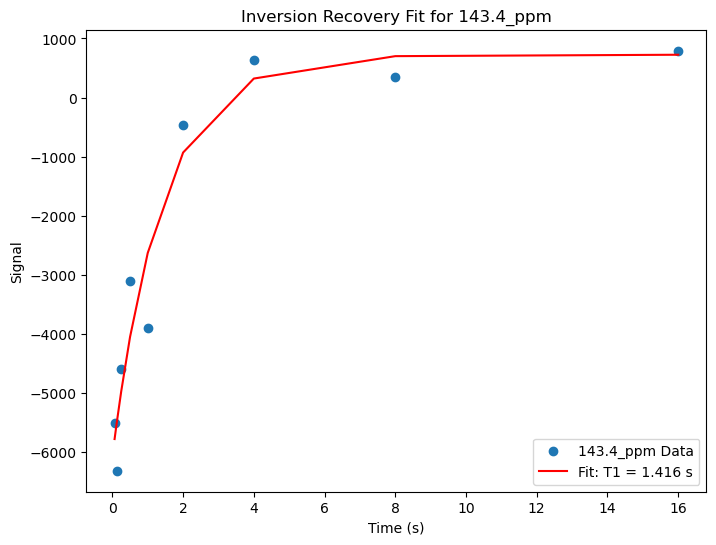

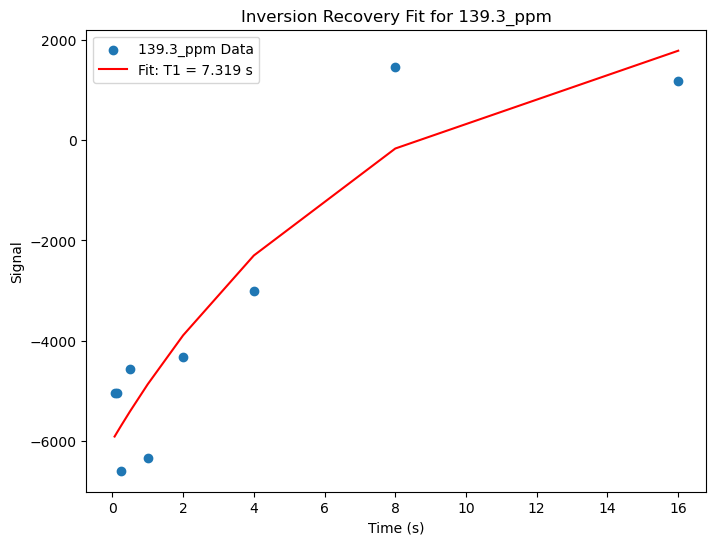

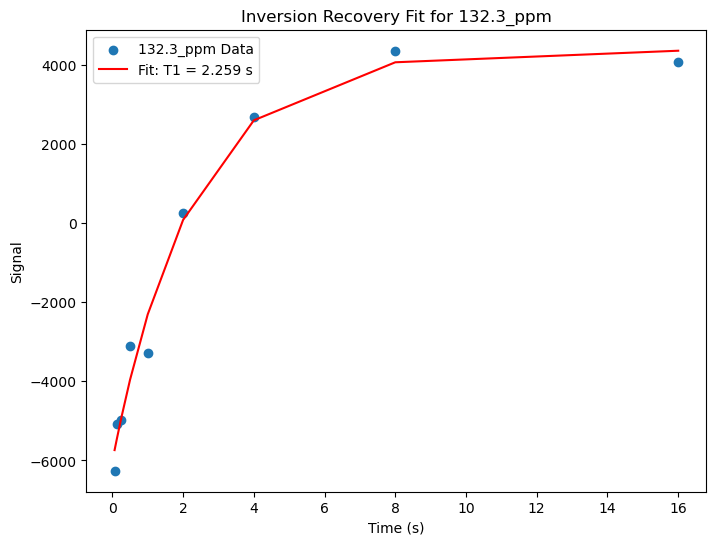

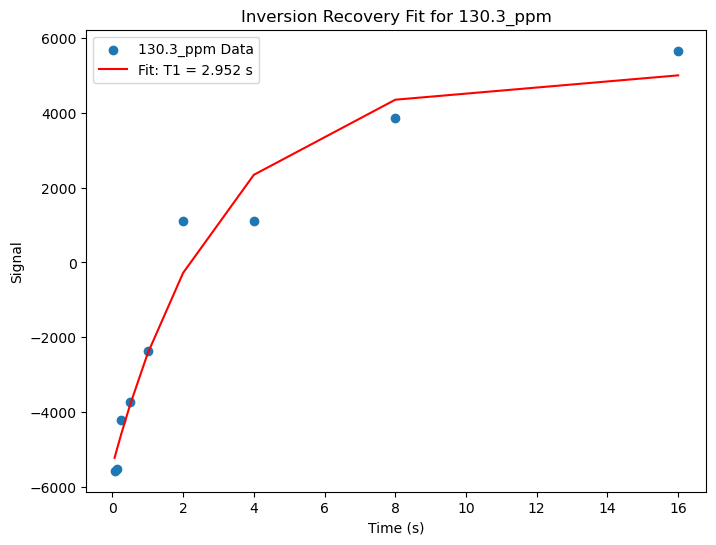

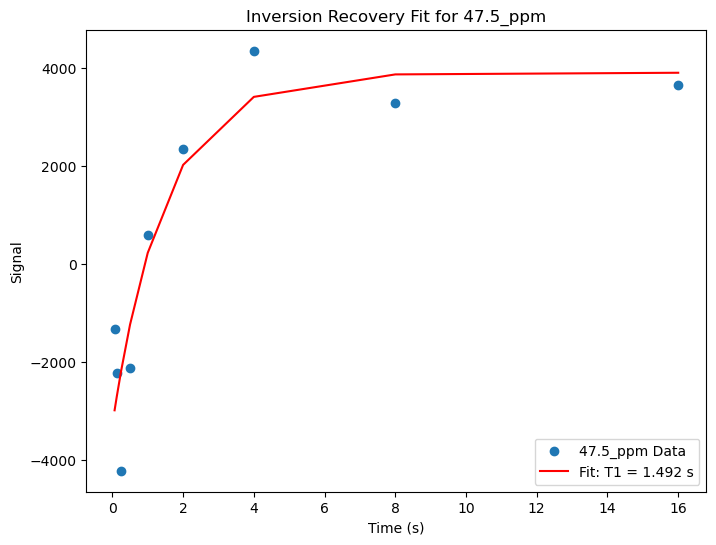

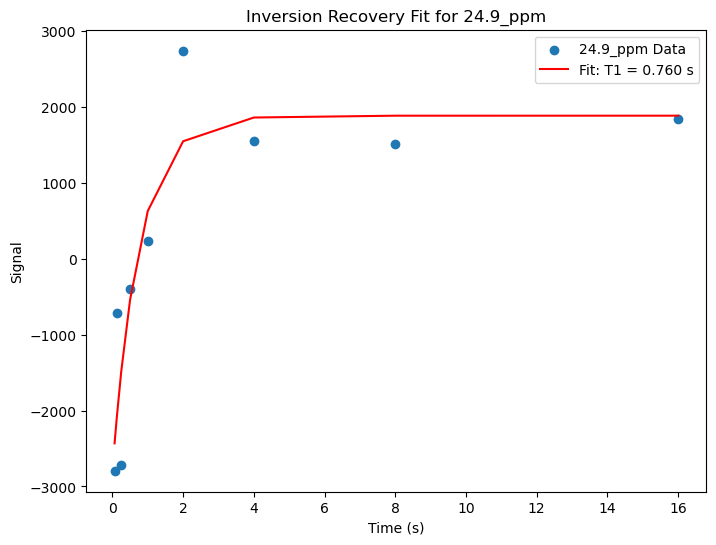

,Peak,T1_Time
0,183.7_ppm,12.860
1,143.4_ppm,1.416
2,139.3_ppm,7.319
3,132.3_ppm,2.259
4,130.3_ppm,2.952
5,47.5_ppm,1.492
6,24.9_ppm,0.760


In [8]:
# Dictionary to store the T1 times
T1_times = {}

# Calculate T1 for each nucleus and plot the fit
for column in df.columns:
    if column != 'Time':
        popt, T1 = calculate_T1(df, 'Time', column)
        T1_times[column] = T1
        plot_fitted_data(df, 'Time', column, popt)

# Create a summary table of T1 times
T1_df = pd.DataFrame(list(T1_times.items()), columns=['Peak', 'T1_Time'])
T1_df


---

## 7. Calculate an ideal delay time (d<sub>1</sub>)

Now, let's calculate an ideal delay time (d<sub>1</sub>) for future NMR experiments on ibuprofen based on the (T<sub>1</sub>) times we measured.

d<sub>1</sub> + aq = 5 * T<sub>1</sub>

aq = acquisition time = 1.3 seconds for ibuprofen

Relaxation time (d<sub>1</sub>) can not be shorter than 0 seconds:

* if d<sub>1</sub> > 0 seconds:

    d<sub>1</sub> = (5 * T<sub>1</sub>) - aq

* else:

    d<sub>1</sub> = 0 seconds

In [11]:
# Define the conditional logic for calculating the relaxation time (d1)
def calculate_d1_time(t1_time : float, aq : float):
    d1 = 5 * t1_time - aq
    if d1 > 0:
        return d1
    else:
        return 0

T1_df['D1_Time'] = T1_df['T1_Time'].apply(calculate_d1_time, aq=1.3)

# Find the largest D1
max_d1 = T1_df['D1_Time'].max()

# Round d1 time to nearest second
max_d1 = round(max_d1)

# Print the ideal d1 time using an f-string
print(f'Ideal d1 time: {max_d1} (s)')
T1_df

Ideal d1 time: 63 (s)


,Peak,T1_Time,D1_Time
0,183.7_ppm,12.860,63.001
1,143.4_ppm,1.416,5.779
2,139.3_ppm,7.319,35.293
3,132.3_ppm,2.259,9.995
4,130.3_ppm,2.952,13.458
5,47.5_ppm,1.492,6.161
6,24.9_ppm,0.760,2.499


---

## 8. Export results

We can save the T<sub>1</sub> and d<sub>1</sub> values we calculated by exporting our summary DataFrame as a .csv file.

You can open the .csv file in excel.

In [17]:
# Define output directory
directory = 'results'

# Make sure the parent directory exists
if not os.path.isdir(directory):
    os.makedirs(directory)

# Export DataFrame to a .csv file
T1_df.to_csv(f'{directory}/ibprofen_t1_d1_summary.csv')